### Homework 3. Связь бизнес-показателей и DS-метрик

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [9]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [10]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [11]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [12]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

## Задание

#### 1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
#### 2. При обучении моделей обязательно использовать кроссвалидацию

In [13]:
classifier_logreg = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

classifier_dtc = Pipeline([
    ('features',feats),
    ('classifier', DecisionTreeClassifier(random_state = 42)),
])

classifier_cbc = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(silent=True, random_state = 42)),
])

y_scores = []

for classifier in [('logreg', classifier_logreg), ('DecisionTree', classifier_dtc), ('Catboost', classifier_cbc)]:
    cv_scores = cross_val_score(classifier[1], X_train, y_train, cv=16, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f'CV score for {classifier[0]} is {cv_score:.4f}+-{cv_score_std:.4f}')

    #обучим пайплайн на всем тренировочном датасете
    classifier[1].fit(X_train, y_train)
    y_score = classifier[1].predict_proba(X_test)[:, 1]
    y_scores.append((classifier[0], y_score))

CV score for logreg is 0.7867+-0.0085
CV score for DecisionTree is 0.6337+-0.0098
CV score for Catboost is 0.8024+-0.0068


#### 3. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
#### 4. Сделать выводы о том, какая модель справилась с задачей лучше других

In [26]:
b=1
scores = dict()
for score in y_scores:
    precision, recall, thresholds = precision_recall_curve(y_test.values, score[1])
    roc_auc = roc_auc_score(y_true=y_test, y_score=score[1])
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    scores[score[0]] = [precision[ix], recall[ix], fscore[ix], roc_auc]
scores = pd.DataFrame(scores, index = ['precision', 'recall', 'f-score', 'roc_auc'])
scores.T

,precision,recall,f-score,roc_auc
logreg,0.647431,0.837558,0.730323,0.784035
DecisionTree,0.496000,1.000000,0.663102,0.635325
Catboost,0.689686,0.797350,0.739621,0.801092


При заданных параметрах лучшие результаты показала модель CatBoostClassifier.

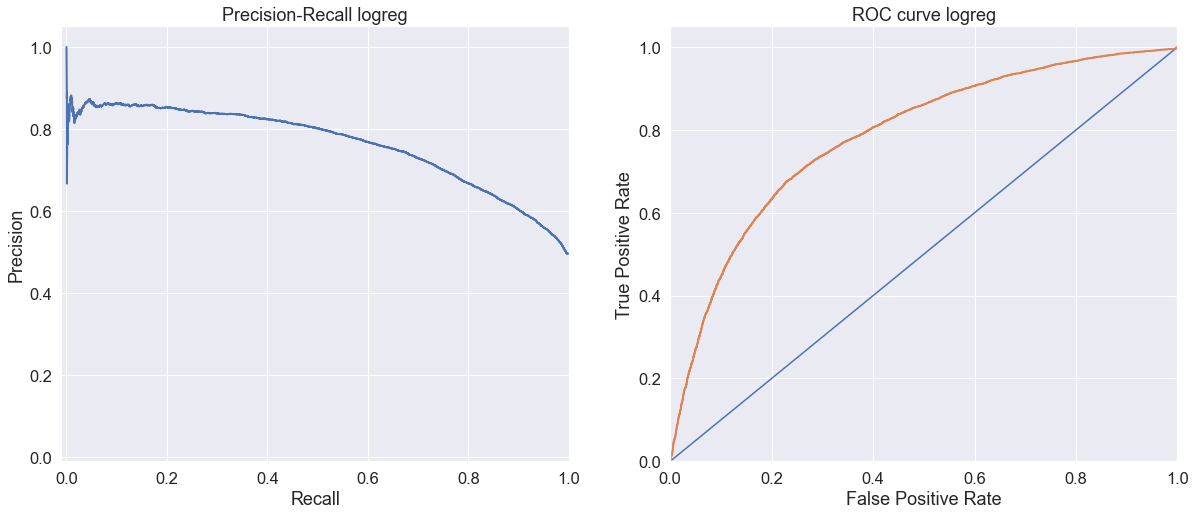

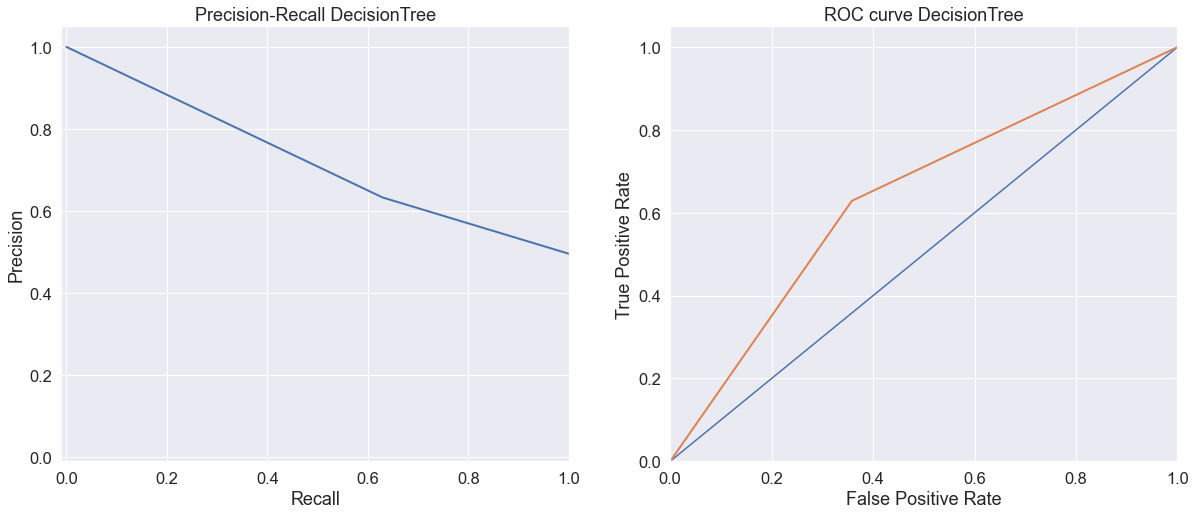

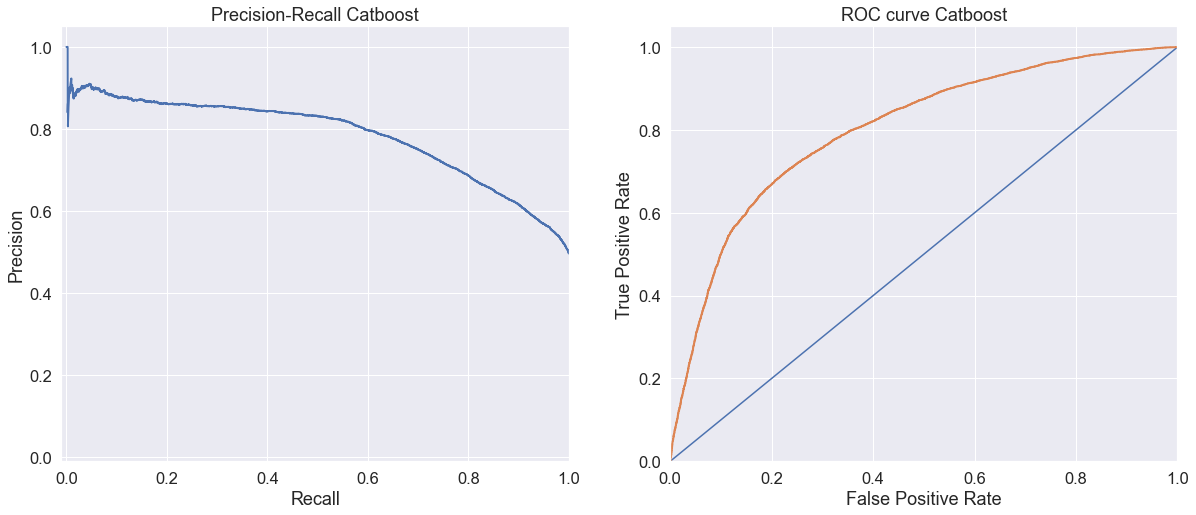

In [33]:
from sklearn.metrics import plot_precision_recall_curve
for score in y_scores:
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")
    plt.figure(figsize=(20, 8))
    precision, recall, _ = precision_recall_curve(y_test.values, score[1])
    fpr, tpr, _ = roc_curve(y_test, score[1], pos_label=1)
    lw = 2
    plt.subplot(1, 2, 1)
    plt.xlim([-0.01, 1.0])
    plt.ylim([-0.01, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall {score[0]}')
    plt.plot(recall, precision, lw=lw, label=f'Precision-Recall {score[0]}')
    plt.subplot(1, 2, 2)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve {score[0]}')
    plt.plot(fpr, tpr, lw=lw, label=f'ROC curve {score[0]}')
    plt.show()

#### 5. (Опциональный вопрос) Какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого, например, 1 к 1000). 
**p.s. В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:
Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:
первая помечает 100 объектов как класс 1, но TP = 90
вторая помечает 1000 объектов как класс 1, но TP такой же - 90
Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?**

В заданном вопросе лучше работает модель, которая предсказала 100 объектов как класс 1. Заметно это будет в первую очередь по метрике precision, которая для второй модели с большим FP сильно упадет.

Соответственно, больше подходит график precision_recall, на графике roc_auc изменения будут не сильно заметны, т.к. TPR (recall) у обеих моделей будет одинаков, а отличия в FPR будут незначительны за счет очень большого знаменателя.